<a href="https://colab.research.google.com/github/NAHIN-JZS/image_colorization/blob/main/Skin_tone_pix2pix_image_colorization_on_RGB_for_larger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model


In [4]:
def define_discriminator(input_image_shape,output_image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=input_image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=output_image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [5]:

def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g


In [6]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [7]:
# define the standalone generator model - U-net
def define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=input_image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model


In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_image_shape,mask_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
            
	# define the source image
	in_src = Input(shape=input_image_shape)
	mask = Input(shape= mask_image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	
	mask_gen_out = tf.math.multiply(gen_out,mask)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model([in_src,mask], [dis_out, gen_out, mask_gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
	model.compile(loss=['binary_crossentropy', 'mae', 'mae'], 
               optimizer=opt, loss_weights=[1,50,50])
	return model

In [9]:

def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [10]:


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [11]:
def summarize_performance(step, g_model, d_model, gan_model, weight_folder):
	# select a sample of input images
	
	# save the generator model
	g_model_filename = weight_folder + '/g_model_%06d.h5' % (step+1)
	g_model.save(g_model_filename)
	print('>Saved: %s' % ( g_model_filename))

	# save the discriminator model
	d_model_filename = weight_folder + '/d_model_%06d.h5' % (step+1)
	d_model.save(d_model_filename)
	print('>Saved: %s' % (d_model_filename))

	# save the gan model
	gan_model_filename = weight_folder + '/gan_model_%06d.h5' % (step+1)
	gan_model.save(gan_model_filename)
	print('>Saved: %s' % ( gan_model_filename))


In [13]:
import tensorflow as tf
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image, ImageOps

In [14]:
# This function will create a list of image path
def generate_image_path_list(folder_name):
  path_list = list() 
  for filename in listdir(folder_name):
    path_list.append(filename)
  return path_list

In [23]:
def generate_mask_path_list(folder_name):
  path_list = list() 
  for filename in listdir(folder_name):
    path_list.append(filename)
  return path_list

In [81]:
# load all images in a directory into memory
def load_images(im_indecator, im_path_list,mask_path_list, im_path,mask_path, batch_size, size=(256,256)):
	src_list, tar_list, mask_list = list(), list(), list()
	# enumerate filenames in directory, assume all are images
	# for filename in listdir(path):
	if ((im_indecator + batch_size) > len(im_path_list)):
		batch_size = len(im_path_list) - im_indecator
	for j in range(batch_size):

		# load and resize the image
		#pixels = load_img(path + filename, target_size=size)
		rgb_image = load_img(path + im_path_list[im_indecator+j], target_size=size)
		# print("rgb_path: ",im_path_list[im_indecator+j])
		gray_image = ImageOps.grayscale(rgb_image)
		# gray_image = tf.image.rgb_to_grayscale(rgb_image)
		# convert to numpy array
		rgb_pixels = img_to_array(rgb_image)
		gray_pixels = img_to_array(gray_image)
		#Loading the mask image
		mask = load_img(mask_path + mask_path_list[im_indecator + j ], target_size=size)
		mask_pixels = img_to_array(mask)
		# print("mask_path : ",mask_path_list[im_indecator + j ])
		# print("mask shape: ",mask_pixels.shape)
		# print("gray shape: ",gray_pixels.shape)
		# print("rgb shape: ",rgb_pixels.shape)


		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(gray_pixels)
		tar_list.append(rgb_pixels)
		mask_list.append(mask_pixels)
	return [asarray(src_list), asarray(tar_list),asarray(mask_list),batch_size] #Returning the batch size so that at the last epoch it can feed it to the generate_real_samples functions.

In [16]:

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]



In [92]:
#X_realA ---> src gray image
#X_realB ---> ground truth color image

# train pix2pix models
# def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):

def train(d_model, g_model, gan_model, im_path_list, mask_path_list, mask_path, im_path, weight_folder, save_weight_file_after = 10, n_epochs=100, n_batch=1):
	"""This function is used to train the GAN

	Args:
		d_model (keras model): discriminator model
		g_model (keras model): generator model
		gan_model (keras model): combine of d_model and g_model or GAN
		im_path_list (list): this will contain all image name in the dataset(main image) folder
		im_path (string): dataset path or image path 
		weight_folder (string): folder to save weight file
		save_weight_file_after (int, optional): number of epoch to save weight file. mane koita wpoch er por weight file save korbe. Defaults to 10.
		n_epochs (int, optional): Total number of epoch. Defaults to 100.
		n_batch (int, optional): number of batch. Defaults to 1.
	"""


	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	# trainA, trainB = dataset
	# calculate the number of batches per training epoch
	# bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	# n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	total_image = len(im_path_list)
	for i in range(n_epochs):
		im_indicator = 0 # Track of current image
		n_last_batch = n_batch # n_last_batch will work as number of batch...but to update after one epoch this has been written
		while (im_indicator < total_image):
				[src_images, tar_images,mask,n_last_batch]  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, mask_path_list= mask_path_list,mask_path= mask_path, batch_size = n_batch)
				
				dataset = preprocess_data([src_images, tar_images])
				print(mask.shape)
				print(tar_images.shape)
				trainA, trainB = dataset

				im_indicator = im_indicator + n_last_batch


				# select a batch of real samples
				[X_realA, X_realB], y_real = generate_real_samples(dataset, n_last_batch, n_patch)
				# generate a batch of fake samples
				X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

				#masking the ground_truth
				print(X_realB.shape)
				mask_tar_out = tf.math.multiply(X_realB,mask)

				# update discriminator for real samples
				d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
				# update discriminator for generated samples
				d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

				

				# update the generator
				g_loss,skin_loss, _, _ = gan_model.train_on_batch([X_realA,mask], [y_real, X_realB,mask_tar_out])
				# summarize performance
				print('>epoch: %d, batch: %d, d1[%.3f] d2[%.3f] g[%.3f] s[%.3f]' % (i+1,np.ceil(im_indicator/n_batch), d_loss1, d_loss2, g_loss, skin_loss))
				# summarize model performance
		if (i+1) %  save_weight_file_after == 0:

			# [src_images, tar_images]  = load_images(im_indicator- n_batch , im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
			# dataset = preprocess_data([src_images, tar_images])
			summarize_performance(i, g_model = g_model, d_model = d_model, gan_model = gan_model, weight_folder = weight_folder)

In [ ]:
# """Checking the load_images function...ignore"""




# path = '/content/gdrive/MyDrive/3200_Project/Project/Zahim_folder/New_Image/'
# path_list = generate_image_path_list(path)
# # load dataset
# [src_images, tar_images] = load_images(im_indecator = 0, im_path_list = path_list, im_path = path, batch_size = 1, size=(256,256))
# print('Loaded: ', src_images.shape, tar_images.shape)


# n_samples = 1
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + i)
# 	pyplot.axis('off')
# 	re = np.squeeze(src_images[i])
# 	pyplot.imshow(re.astype('uint8'),'gray')
# # plot target image
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + n_samples + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(tar_images[i].astype('uint8'))
# pyplot.show()

#######################################



In [73]:

#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
# input_image_shape = src_images.shape[1:]
input_image_shape = (256,256,1)
output_image_shape = (256,256,3)
mask_image_shape = (256,256,1)
# output_image_shape = tar_images.shape[1:]
# print("Input image shape ",input_image_shape)
# print("Output image shape ",output_image_shape)

# define the models
d_model = define_discriminator(input_image_shape,output_image_shape)
g_model = define_generator(input_image_shape,output_image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, input_image_shape,mask_image_shape)

#Define data
# load and prepare training images
# dataset = [src_images, tar_images]


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# trainA, trainB = dataset
# trainA[12].shape

NameError: ignored

In [ ]:
# dataset = preprocess_data(data)

In [74]:
path = '/content/gdrive/MyDrive/Thesis/Dataset/skin_tone_clothing/skin_segmentation_images_original/'
weight_folder = '/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1'
path_list = generate_image_path_list(path)
path_list.sort()
print(np.array(path_list).shape)

(1000,)


In [75]:
path_list[61]

'img_0062.png'

In [76]:
mask_path = '/content/gdrive/MyDrive/Thesis/Dataset/skin_tone_clothing/skin_segmentation_masks_original_0_1/'
mask_path_list = generate_mask_path_list(mask_path)
mask_path_list.sort()
print(np.array(mask_path_list).shape)

(1000,)


In [77]:
mask_path_list[61]

'seg_0062.png'

In [94]:
from datetime import datetime 
start1 = datetime.now() 

# train(d_model, g_model, gan_model, dataset, n_epochs=150, n_batch=1) 
train(d_model, g_model, gan_model, im_path_list = path_list, mask_path_list = mask_path_list, im_path = path, mask_path = mask_path, weight_folder = weight_folder, n_epochs=100, n_batch=64)
stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)


(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 231ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 1, d1[0.282] d2[0.249] g[6.106] s[1.241]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 159ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 2, d1[0.244] d2[0.281] g[6.109] s[1.167]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 157ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 3, d1[0.252] d2[0.345] g[6.666] s[1.166]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 155ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 4, d1[0.307] d2[0.231] g[6.302] s[1.248]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 157ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 5, d1[0.335] d2[0.356] g[6.294] s[1.072]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 160ms/step
(64, 256, 256, 3)
>epoch: 1, batch: 6, d1[0.337] d2[0.391] g[6.927] s[1.132]
(64,

>epoch: 10, batch: 16, d1[0.323] d2[0.407] g[5.667] s[0.912]
>Saved: /content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/g_model_000010.h5
>Saved: /content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/d_model_000010.h5
>Saved: /content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/gan_model_000010.h5
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 256ms/step
(64, 256, 256, 3)
>epoch: 11, batch: 1, d1[0.416] d2[0.374] g[5.290] s[0.907]
(64, 256, 256, 3)
(64, 256, 256, 3)
2/2 [==============================] - 0s 160ms/step
(64, 256, 256, 3)
>epoch: 11, batch: 2, d1[0.378] d2[0.354] g[5.143] s[0.912]


KeyboardInterrupt: ignored

In [95]:
#Test trained model on image...

from keras.models import load_model
from numpy.random import randint
# model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/model_000002.h5')
g_model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint1/g_model_000010.h5')

In [98]:
#function to load a single image for test
def load_single_images(path, size=(256,256)):
    src_list, tar_list = list(), list()
    rgb_image = load_img(path, target_size=size)
    gray_image = ImageOps.grayscale(rgb_image)
    # gray_image = tf.image.rgb_to_grayscale(rgb_image)
    # convert to numpy array
    rgb_pixels = img_to_array(rgb_image)
    gray_pixels = img_to_array(gray_image)
    # split into satellite and map
    #sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_pixels)
    tar_list.append(rgb_pixels)
    return [asarray(src_list), asarray(tar_list)]

In [97]:
# test_data = load_single_images('/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20056.jpg')
path = '/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_HR/'
path_list_t = generate_image_path_list('/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_HR/')
test_data = load_images(im_indecator= 0, im_path_list = path_list_t, im_path = '/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_HR/', batch_size= 16, size=(256,256))

TypeError: ignored

In [112]:
test_data = load_single_images('/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0020.png')

In [113]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
  
  images = vstack(( gen_img, tar_img))
  #images = src_img
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  pyplot.subplot(1,3,1)
  pyplot.axis('off')
  re = np.squeeze(src_image)
  pyplot.imshow(re,'gray')
  pyplot.title(titles[0])
  # plot images row by row
  for i in range(len(images)):
    
    # define subplot
    pyplot.subplot(1, 3, 2 + i)# turn off axis
    pyplot.axis('off')# plot raw pixel data
    pyplot.imshow(images[i])# show title
    pyplot.title(titles[i+1])
  print(images.shape)
  # pyplot.subplot(1,3,1)
  # pyplot.imshow(images[0,:,:,:])
  pyplot.show()



#[X1, X2] = dataset
# select random example
#ix = randint(0, len(X1), 1)
#src_image, tar_image = X1[ix], X2[ix]
# src_image, tar_image = test_data
src_image, tar_image = preprocess_data(test_data)
# generate image from source
gen_image = g_model.predict(src_image)
# plot all three images
# plot_images(src_image, gen_image, tar_image)

1/1 [==============================] - 0s 19ms/step


In [114]:
re = np.squeeze(src_image)
re.shape

(256, 256)

In [115]:
gen_image.shape

(1, 256, 256, 3)

In [116]:
gen_image = np.squeeze(gen_image)

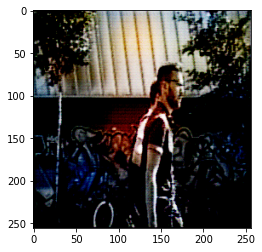

In [117]:
plt.imshow(gen_image)
plt.show()

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0);print(act1.shape,act2.shape)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
# images1 = randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))


In [ ]:
images1 = tar_image
images2 = gen_image
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
(16, 2048) (16, 2048)
FID (same): -0.000
(16, 2048) (16, 2048)
FID (different): 1.052


In [ ]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
import numpy as np

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
(images1, _), (images2, _) = cifar10.load_data()
shuffle(images1)
images1 = images1[:1]
print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images1, (299,299,3))

print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images1)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Loaded (1, 32, 32, 3) (10000, 32, 32, 3)
Scaled (299, 299, 3) (1, 299, 299, 3)


ValueError: ignored